In [20]:
import os, torch
#from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
import interflow.realnvp as realnvp
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA available, setting default tensor residence to GPU.
cuda
Torch version: 2.5.1


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Device] Using: {device} | CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")
if device.type == "cuda":
    try:
        print("[Device] GPU:", torch.cuda.get_device_name(0))
        torch.backends.cudnn.benchmark = True
    except Exception as _e:
        print("[Device] GPU name unavailable:", _e)

def move_to(obj, device=device, non_blocking=True):
    """Recursively move tensors in nested containers to device."""
    import torch
    if torch.is_tensor(obj):
        return obj.to(device=device, non_blocking=non_blocking)
    if isinstance(obj, dict):
        return {k: move_to(v, device, non_blocking) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        seq = [move_to(x, device, non_blocking) for x in obj]
        return type(obj)(seq) if isinstance(obj, tuple) else seq
    return obj

print("[Device] Helper move_to() is defined.")


[Device] Using: cuda | CUDA_VISIBLE_DEVICES=0
[Device] GPU: NVIDIA A100 80GB PCIe
[Device] Helper move_to() is defined.


In [22]:
# --- Try moving common models/modules to the selected device ---
for _name in ['v', 'model', 'net', 'flow', 'flow_model', 'interpolant', 'b', 's']:
    if _name in globals():
        _obj = globals()[_name]
        try:
            # nn.Module or object exposing .to()
            _obj.to(device)  # type: ignore
            try:
                import torch
                p = next(_obj.parameters())
                print(f"[Move] {_name}: parameters on {p.device}")
            except Exception:
                print(f"[Move] {_name}: moved via .to(device)")
        except Exception as e:
            print(f"[Move] Skip {_name}: {e}")


[Move] v: parameters on cuda:0
[Move] interpolant: parameters on cuda:0


# Adversarial training of nonlinear SI to solve Schrödinger Bridge 

## Utility functions

In [23]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    with torch.no_grad():
        x0_tests  = base(bs)
        xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        # ([1, bs, dim], [bs])
        x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_sde, xf_pflow, logpx_pflow


def log_metrics(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    b_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    b_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    b_loss   = grab(b_loss).mean(); data_dict['b_losses'].append(b_loss)
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean(); data_dict['losses'].append(loss)
    b_grad   = grab(b_grad).mean(); data_dict['b_grads'].append(b_grad)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)

    
    # compute and log likelihood data
    _, _, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs)
    
    logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    
    
def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_sde, xf_pflow, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs
    )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,2, figsize=(16,4))
    #print("EPOCH:", counter)
    #print("LOSS, GRAD:", loss, b_grad, s_grad)


    ## plot loss over time.
    #nsaves = len(data_dict['losses'])
    #epochs = np.arange(nsaves)*metrics_freq
    #axes[0].plot(epochs, data_dict['losses'], label=" b + s")
    #axes[0].plot(epochs, data_dict['b_losses'], label="b")
    #xes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    #xes[0].set_title("LOSS")
    #axes[0].legend()


    # plot samples from SDE.
    axes[0].scatter(
        xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2)
    axes[0].set_xlim(-5,5)
    axes[0].set_ylim(-6.5,6.5)
    axes[0].set_title("Samples from SDE", fontsize=14)


    # plot samples from pflow
    axes[1].scatter(
        xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    axes[1].set_xlim(-5,5)
    axes[1].set_ylim(-6.5,6.5)
    axes[1].set_title("Samples from PFlow", fontsize=14)


    ## plot likelihood estimates.
    #axes[3].plot(epochs, data_dict['logps_pflow'],   label='pflow', color='purple')
    #axes[3].set_title(r"$\log p$ from PFlow")
    #axes[3].legend(loc='best')
    #axes[3].set_ylim(-7,0)


    fig.suptitle(r"$\epsilon = $" + str(grab(eps)),  fontsize=16, y = 1.05)
    plt.show()
    
    

### Training Functions

In [29]:
def total_grad_norm(params):
    norms = []
    for p in params:
        if p.grad is not None:
            norms.append(p.grad.detach().pow(2).sum())
    if not norms:
        return 0.0
    return (torch.stack(norms).sum().sqrt()).item()

def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad_(flag)
        
def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    v: torch.nn.Module,
    opt_v: torch.optim.Optimizer,
    opt_flow: torch.optim.Optimizer,  # Changed from opt_T to opt_flow for clarity
    sched_v: torch.optim.lr_scheduler._LRScheduler, 
    sched_flow: torch.optim.lr_scheduler._LRScheduler,  # Changed from sched_T to sched_flow for clarity
    n_inner: int = 1,  # Number of inner minimization steps
    n_outer: int = 1,  # Number of outer maximization steps
    reuse_batch: bool = True,
    clip_v: float = 1.0,
    clip_flow: float = 1.0,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    """
    Take a single step of adversarial training.
    Inner loop: minimize loss w.r.t. v
    Outer loop: maximize loss w.r.t. interpolant.flow_model
    """
    v.train()
    interpolant.flow_model.train()
    if reuse_batch:
        # construct batch
        x0s = base(bs)
        x1s = target(bs)
        ts  = torch.rand(size=(bs,))
    
    # Inner minimization: minimize over v
    set_requires_grad(interpolant.flow_model, False)
    set_requires_grad(v, True)
    
    v_grad_val = 0.0
    for _ in range(n_inner):
        if not reuse_batch:
            x0s = base(bs).to(device)
            x1s = target(bs).to(device)
            ts  = torch.rand(bs, device=device)
            
        opt_v.zero_grad(set_to_none = True)
        loss_v = loss_fn_v(v, x0s, x1s, ts, interpolant)
        loss_v.backward()
        
        if clip_v is not None and clip_v < float('inf'):
            torch.nn.utils.clip_grad_norm_(v.parameters(), clip_v)
        v_grad_val = total_grad_norm(v.parameters())
        
        opt_v.step()
        sched_v.step()
    
    # Outer maximization: maximize over interpolant.flow_model
    set_requires_grad(v, False)
    set_requires_grad(interpolant.flow_model, True)
    
    flow_grad_val = 0.0
    for _ in range(n_outer):
        if not reuse_batch:
            x0s = base(bs).to(device)
            x1s = target(bs).to(device)
            ts  = torch.rand(bs, device=device)
            
        opt_flow.zero_grad(set_to_none = True)
        loss_flow = loss_fn_v(v, x0s, x1s, ts, interpolant)
        
        (-loss_flow).backward()  # Negative for maximization
        
        if clip_flow is not None and clip_flow < float('inf'):
            torch.nn.utils.clip_grad_norm_(interpolant.flow_model.parameters(), clip_flow)
        flow_grad_val = total_grad_norm(interpolant.flow_model.parameters())        
        
        opt_flow.step()
        sched_flow.step()
    
    # re-enable grads for next call
    set_requires_grad(v, True)
    set_requires_grad(interpolant.flow_model, True)
    
    # Return the final loss values and gradients for logging
    return loss_v.detach(), loss_flow.detach(), torch.tensor(v_grad_val), torch.tensor(flow_grad_val)

### Define target

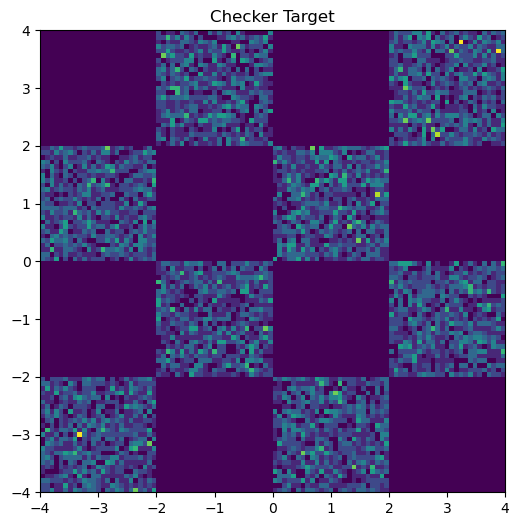

Batch Shape: (10000, 2)


In [6]:
ndim = 2
def target(bs):
    x1 = torch.rand(bs, dtype=torch.float32) * 4 - 2
    x2_ = torch.rand(bs, dtype=torch.float32) - torch.randint(2, (bs,), dtype=torch.float32) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)


target_samples = grab(target(10000))


fig = plt.figure(figsize=(6,6))
plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-4,4],[-4,4]]);
plt.title("Checker Target")
plt.show()


print("Batch Shape:", target_samples.shape)
# target_logp_est = target.log_prob(target(10000)).mean()

### Define Base Distribution

In [7]:
base_loc     = torch.zeros(ndim, device=device, dtype=torch.float32)
base_var     = torch.ones(ndim, device=device, dtype=torch.float32)
base         = prior.SimpleNormal(base_loc, 1.0*base_var)
base_samples = grab(torch.tensor(base(20000),dtype=torch.float32))









/tmp/ipykernel_2310860/2389798472.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  base_samples = grab(torch.tensor(base(20000),dtype=torch.float32))


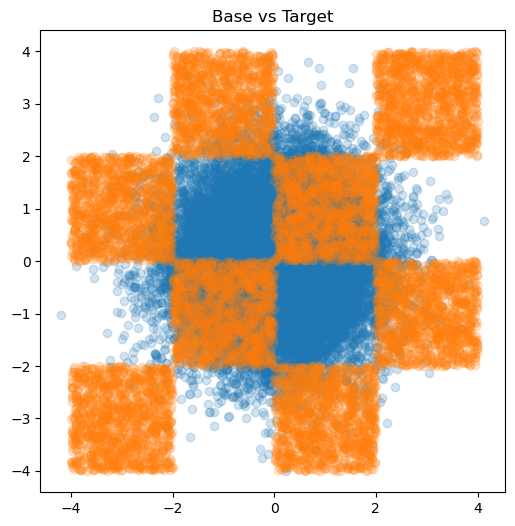

In [8]:
fig = plt.figure(figsize=(6,6,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.2);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

### Define Interpolant: A nonlinear interpolant.

In [9]:
path = "nonlinear"
flow_config = {
    "num_layers": 4,
    "time_embed_dim": 128,
    "hidden": 128,
    "mlp_blocks": 4,
    "activation": "gelu",
    "use_layernorm": False,
    "use_permutation": True
    }

data_type = "vector"
data_dim = 2

interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type = None,\
    flow_config=flow_config, data_type=data_type, data_dim=data_dim)

# check trainable parameters
# These should be the same object
print(f"self.It is bound to flow_model: {interpolant.It.__self__ is interpolant.flow_model}")

# Check trainable parameters
trainable_params = sum(p.numel() for p in interpolant.flow_model.parameters())
print(f"Flow model has {trainable_params:,} trainable parameters")





self.It is bound to flow_model: True
Flow model has 265,736 trainable parameters


### Define losses for v

In [10]:
loss_fn_v = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-v')

### Define optimizers

In [26]:
base_lr_v      = 2e-4
base_lr_flow   = 5e-5  # learning rate for flow model (T_t)
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = True


v         = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_v     = torch.optim.AdamW(v.parameters(), lr=base_lr_v, betas=(0.5,0.9), weight_decay=1e-4)
opt_flow  = torch.optim.AdamW(interpolant.flow_model.parameters(), lr=base_lr_flow, betas=(0.5,0.9), weight_decay=1e-4)
sched_v   = torch.optim.lr_scheduler.StepLR(optimizer=opt_v, step_size=1500, gamma=0.4)
sched_flow = torch.optim.lr_scheduler.StepLR(optimizer=opt_flow, step_size=1500, gamma=0.4)


eps          = torch.tensor(0)
N_epoch      = 100
bs           = 2000    # Increased batch size for better GPU utilization
n_inner      = 3     # inner minimization steps for v
n_outer      = 1     # outer maximization steps for flow model

# plot_bs      = 5000  # number of samples to use when plotting
# metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
# plot_freq    = 500   # how often to plot
# n_save       = 10    # how often to checkpoint SDE integrator
# loss_fac     = 4.0   # ratio of learning rates for w to v
# n_step       = 100   # number of steps taken by the SDE in [0,1]

if print_model:
    print("Here's the model v:", v)

Here's the model v: InputWrapper(
  (v): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [27]:
data_dict = {
    'v_losses': [],
    'flow_losses': [],  # Changed from T_losses
    'v_grads': [],
    'flow_grads': [],   # Changed from T_grads
    'times': [],
    'logps_pflow': [],
}

counter = 1

## Training Loop with Adversarial Training

In [28]:
# Example training loop with parameter verification
import copy

# Store initial parameters
initial_v_params = copy.deepcopy(list(v.parameters())[0].data.clone())
initial_flow_params = copy.deepcopy(list(interpolant.flow_model.parameters())[0].data.clone())

for epoch in range(N_epoch):  # Run for a few epochs to test
    # Take a training step with adversarial training
    loss_v, loss_flow, v_grad, flow_grad = train_step(
        bs=bs,
        interpolant=interpolant,
        v=v,
        opt_v=opt_v,
        opt_flow=opt_flow,
        sched_v=sched_v,
        sched_flow=sched_flow,
        n_inner=3,
        n_outer=1,
        reuse_batch=False,
        clip_v=float('inf'),
        clip_flow=float('inf'),
        #device=device,
    )

    
    # Log metrics
    data_dict['v_losses'].append(grab(loss_v).mean())
    data_dict['flow_losses'].append(grab(loss_flow).mean())
    data_dict['v_grads'].append(grab(v_grad).mean())
    data_dict['flow_grads'].append(grab(flow_grad).mean())
    
    # Print with gradient info for verification
    print(f"Epoch {epoch+1}: v_loss={loss_v.detach().item():.4f}, "
        f"flow_loss={loss_flow.detach().item():.4f}, "
        f"v_grad={v_grad.detach().item():.4f}, "
        f"flow_grad={flow_grad.detach().item():.4f}")    
    counter += 1

Epoch 1: v_loss=-0.1115, flow_loss=-0.1466, v_grad=1.0302, flow_grad=0.6061
Epoch 2: v_loss=-0.2051, flow_loss=-0.2468, v_grad=1.1065, flow_grad=0.7766
Epoch 3: v_loss=-0.3472, flow_loss=-0.4152, v_grad=1.2173, flow_grad=1.0710
Epoch 4: v_loss=-0.5470, flow_loss=-0.6270, v_grad=1.5389, flow_grad=1.7557
Epoch 5: v_loss=-0.7544, flow_loss=-0.8023, v_grad=1.7574, flow_grad=3.0788
Epoch 6: v_loss=-0.8596, flow_loss=-1.1139, v_grad=1.7410, flow_grad=2.9844
Epoch 7: v_loss=-1.1035, flow_loss=-1.4519, v_grad=1.4235, flow_grad=4.2224
Epoch 8: v_loss=-1.4746, flow_loss=-1.5049, v_grad=1.7696, flow_grad=5.4466
Epoch 9: v_loss=-1.3842, flow_loss=-1.5733, v_grad=1.2979, flow_grad=6.3840
Epoch 10: v_loss=-1.7514, flow_loss=-1.5111, v_grad=1.0890, flow_grad=6.5284
Epoch 11: v_loss=-1.6004, flow_loss=-1.7773, v_grad=0.9935, flow_grad=7.2546
Epoch 12: v_loss=-1.6596, flow_loss=-1.6808, v_grad=1.0514, flow_grad=7.4598
Epoch 13: v_loss=-1.3859, flow_loss=-1.3970, v_grad=0.8296, flow_grad=6.7745
Epoch 14

In [42]:
os.makedirs("checkpoints", exist_ok=True)

torch.save({
    "v": v.state_dict(),
    "flow": interpolant.flow_model.state_dict(),
}, "checkpoints/weights_only.pt")

#ckpt = torch.load("checkpoints/weights_only.pt", map_location=device)
#v.load_state_dict(ckpt["v"])
#interpolant.flow_model.load_state_dict(ckpt["flow"])

### Post Training

In [34]:
ckpt = torch.load("checkpoints/weights_only.pt", map_location=device)
v.load_state_dict(ckpt["v"])
interpolant.flow_model.load_state_dict(ckpt["flow"])

/tmp/ipykernel_3554308/1742592006.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints/weights_only.pt", map_location=device)


<All keys matched successfully>

### Train v